In [1]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np

# Read data

In [2]:
import pickle

data_dir = "/data/jdli/gaia/"
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"


with open(tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


### note: labels are n*2, the first column is TEFF, the second is Log g.

In [3]:
bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']

teff_tr = data_tr['labels'][:,0]

bp_val, rp_val = data_val['bp_coef'], data_val['rp_coef']

teff_val = data_val['labels'][:,0]

In [4]:
def designfit(design,labels):
    return (np.linalg.solve(np.matmul(design.transpose(),design),np.matmul(design.transpose(),labels)))

In [5]:
rpANDbp_tr = np.concatenate((rp_tr,bp_tr),axis=1)
rpANDbp_tr = np.array([row/row[0] for row in rpANDbp_tr])
rpANDbp_val = np.concatenate((rp_val,bp_val),axis=1)
rpANDbp_val = np.array([row/row[0] for row in rpANDbp_val])

76.3782765791043

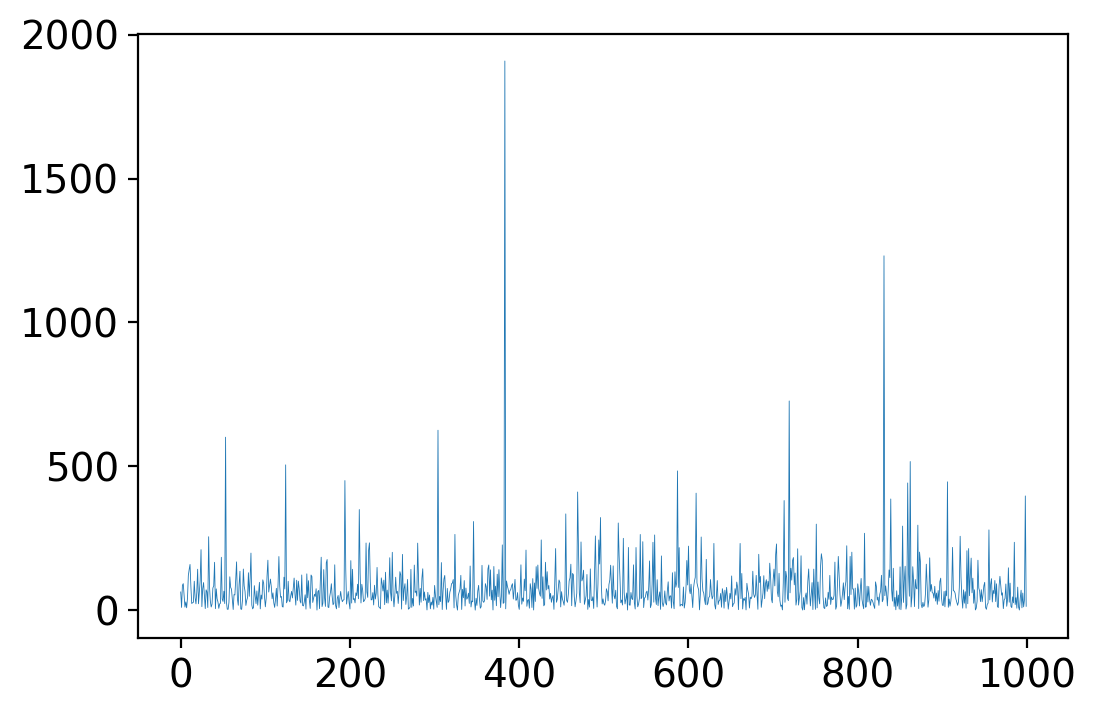

In [6]:
pars = designfit(rpANDbp_tr,teff_tr)
plt.plot(abs(np.matmul(rpANDbp_val,pars)-teff_val),linewidth=0.3)
np.mean(abs(np.matmul(rpANDbp_val,pars)-teff_val))

In [7]:
rpnormed_tr = np.array([row/row[0] for row in rp_tr])
quadraticrp_tr = np.empty((len(rpnormed_tr),int(len(rpnormed_tr[0])*(len(rpnormed_tr[0])+1)/2)))

for i in range(len(rpnormed_tr)):
    row_els = np.concatenate([[np.outer(rpnormed_tr[i],rpnormed_tr[i])[j,j:len(rpnormed_tr[0])]] for j in range(len(rpnormed_tr[0]))],axis=None)
    quadraticrp_tr[i,:] = row_els[:]
    
rpnormed_val = np.array([row/row[0] for row in rp_val])
quadraticrp_val = np.empty((len(rpnormed_val),int(len(rpnormed_val[0])*(len(rpnormed_val[0])+1)/2)))

for i in range(len(rpnormed_val)):
    row_els = np.concatenate([[np.outer(rpnormed_val[i],rpnormed_val[i])[j,j:len(rpnormed_val[0])]] for j in range(len(rpnormed_val[0]))],axis=None)
    quadraticrp_val[i,:] = row_els[:]

121.75619911793801

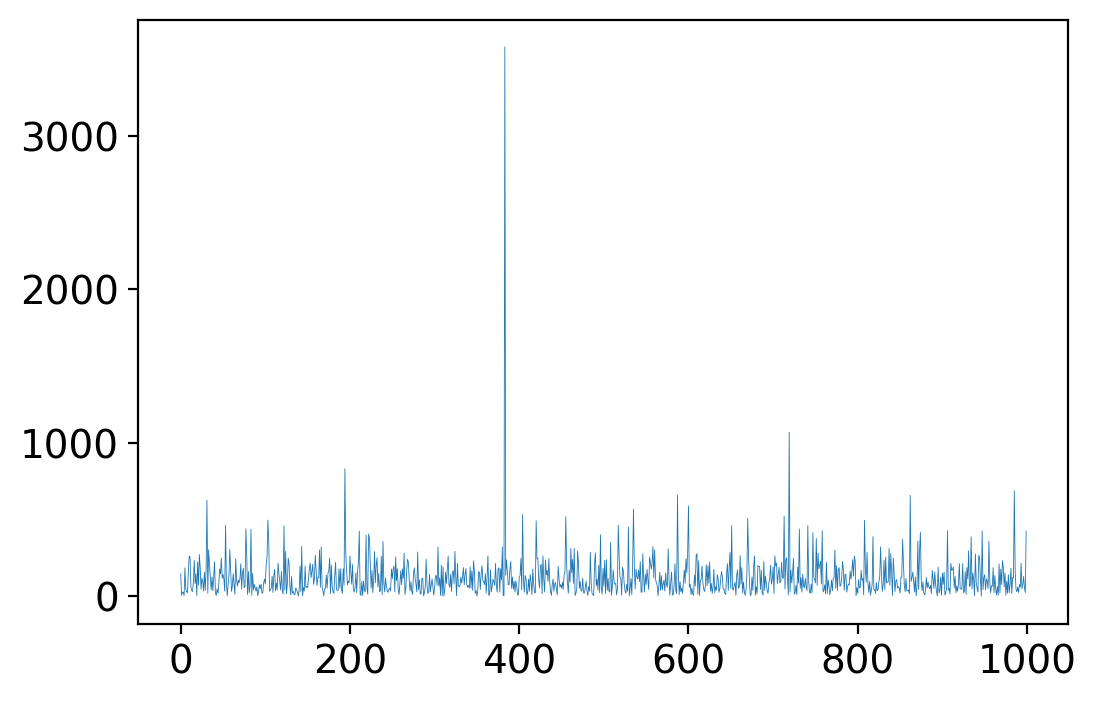

In [8]:
pars2 = designfit(rpnormed_tr,teff_tr)
plt.plot(abs(np.matmul(rpnormed_val,pars2)-teff_val),linewidth=0.3)
np.mean(abs(np.matmul(rpnormed_val,pars2)-teff_val))

229.49013636752008

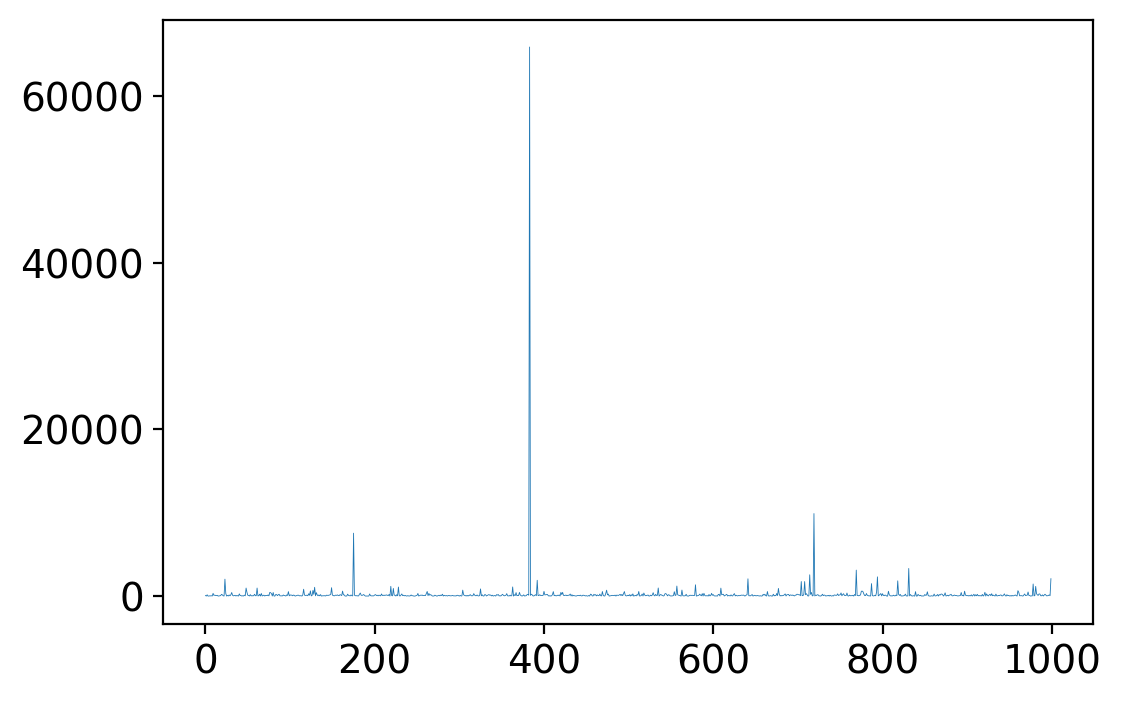

In [9]:
pars3 = designfit(quadraticrp_tr,teff_tr)
plt.plot(abs(np.matmul(quadraticrp_val,pars3)-teff_val),linewidth=0.3)
np.mean(abs(np.matmul(quadraticrp_val,pars3)-teff_val))

In [10]:
#Extracting data
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pickle.load(handle).T # check out that pesky little `.T`

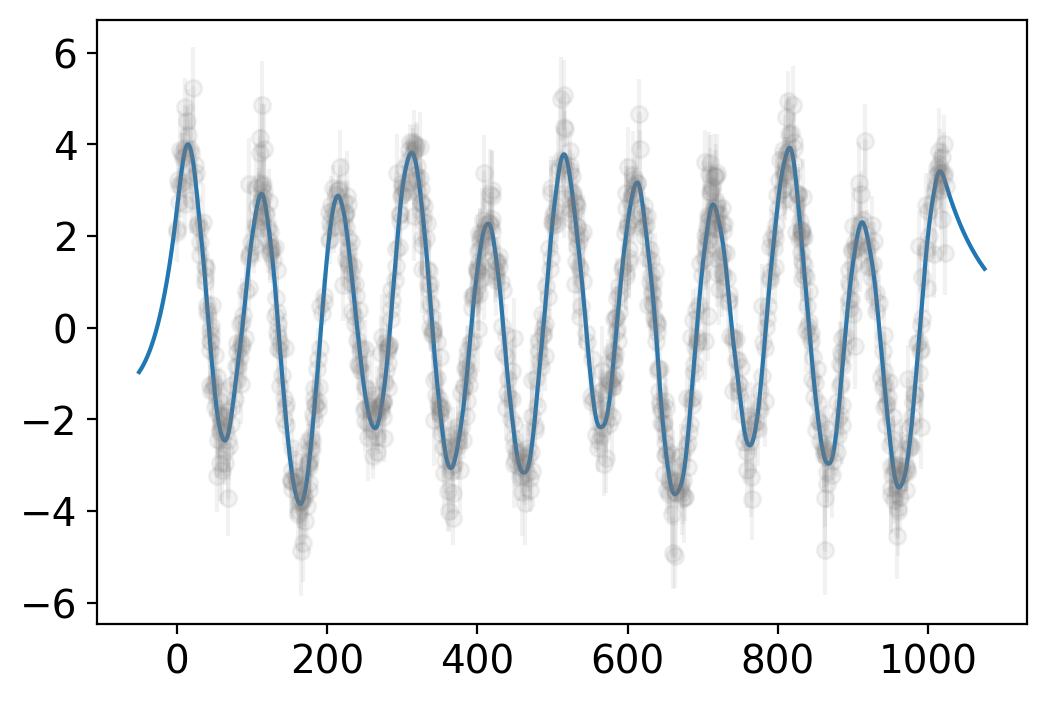

In [11]:
matern3d2 = lambda d, sigma, tau : sigma**2 * (1 + np.sqrt(3)*d/tau) * np.exp(-np.sqrt(3)*d/tau)
sigma = 10
tau = 100

times_tr_1, times_tr_2 = np.meshgrid(data[0],data[0])
distances_tr = np.abs(times_tr_1-times_tr_2)
kernel_tr = matern3d2(distances_tr,sigma,tau)
for i in range(len(kernel_tr)):
    kernel_tr[i,i] = kernel_tr[i,i] + data[1,i]
    
times_eval = np.arange(-50,1075+0.1,0.1)
times_eval_1, times_eval_2 = np.meshgrid(data[0],times_eval)
distances_eval = np.abs(times_eval_1-times_eval_2)
kernel_eval = matern3d2(distances_eval,sigma,tau)

plt.errorbar(data[0],data[12],marker='o',color='gray',alpha=0.1, yerr=data[1])
plt.plot(times_eval,np.matmul(kernel_eval,np.linalg.solve(kernel_tr,data[12])))